# **Initial Dataset Setup and Loading**

## **Install Required Dependencies**

In [18]:
!pip install umap-learn[plot]
!pip install plotly

## **Mount Google Drive**

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Import Required Libraries**

In [20]:
import pandas as pd
import numpy as np
import datetime as dt
from collections import Counter

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize': (15, 8)})

from matplotlib import rcParams
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Dimensionality reduction and statistical analysis libraries
import umap
import umap.plot
from scipy.stats import skew
import scipy.stats as stats

# Miscellaneous settings
import warnings
warnings.filterwarnings("ignore")

## **Load Training Dataset**

In [21]:
train = pd.read_csv('/content/drive/MyDrive/fraudTrain.csv')
train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


# **Initial Data Cleaning**

In [22]:
# Drop 'Unnamed: 0' column
df = train.copy()
df.drop(columns=['Unnamed: 0'], errors='ignore', inplace=True)
print("Dropped 'Unnamed' column")

Dropped 'Unnamed' column


In [23]:
# Drop duplicate values
df.drop_duplicates(inplace=True)
print("Duplicate values dropped successfully")

Duplicate values dropped successfully


In [24]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


In [25]:
# Print number of unique values for each column
train_unique = df.nunique()
print("Unique values in each column:\n", train_unique)

Unique values in each column:
 trans_date_trans_time    1274791
cc_num                       983
merchant                     693
category                      14
amt                        52928
first                        352
last                         481
gender                         2
street                       983
city                         894
state                         51
zip                          970
lat                          968
long                         969
city_pop                     879
job                          494
dob                          968
trans_num                1296675
unix_time                1274823
merch_lat                1247805
merch_long               1275745
is_fraud                       2
dtype: int64


# **Dataset Overview**

In [26]:
# Print basic overview of the dataset
df_info = df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

## **Job Recategorization**

In [27]:
# Define job categories and their respective job titles
job_categories = {
    'Healthcare & Medical': [
        'Psychologist, counselling', 'Psychologist, forensic', 'Psychologist, sport and exercise',
        'Doctor, hospital', 'Doctor, general practice', 'Psychiatrist', 'Psychotherapist',
        'Physiotherapist', 'Occupational therapist', 'Clinical psychologist', 'Paediatric nurse',
        'Pharmacist, hospital', 'Medical sales representative', 'Radiographer, diagnostic',
        'Diagnostic radiographer', 'Surgeon', 'Nurse, mental health', 'Nurse, children\'s'
    ],
    'Engineering & Technical': [
        'Civil engineer', 'Electrical engineer', 'Systems developer', 'Mechanical engineer',
        'Engineer, land', 'Engineer, mining', 'Engineer, technical sales', 'Engineer, communications',
        'Engineer, structural', 'Engineer, production', 'Engineer, civil (contracting)',
        'Engineer, aeronautical', 'Mining engineer', 'Automotive engineer', 'Petroleum engineer'
    ],
    'Education & Research': [
        'Teacher, secondary school', 'Teacher, primary school', 'Special educational needs teacher',
        'Lecturer, higher education', 'Research scientist (physical sciences)', 'Research scientist (medical)',
        'Research scientist (maths)', 'Research officer', 'Higher education careers adviser',
        'Education officer, museum', 'English as a foreign language teacher'
    ],
    'Creative & Design': [
        'Designer, multimedia', 'Designer, furniture', 'Graphic designer', 'Artist', 'Fine artist',
        'Film/video editor', 'Television camera operator', 'Broadcast presenter', 'Art gallery manager',
        'Producer, television/film/video', 'Animator', 'Multimedia programmer', 'Interior designer',
        'Architect', 'Illustrator'
    ],
    'Business & Finance': [
        'Investment banker', 'Financial analyst', 'Accountant, chartered', 'Tax inspector',
        'Corporate investment banker', 'Financial adviser', 'Insurance broker', 'Pensions consultant',
        'Financial trader', 'Chief Financial Officer', 'Chief Executive Officer', 'Chief Technology Officer'
    ],
    'Legal & Law Enforcement': [
        'Barrister', 'Solicitor', 'Legal secretary', 'Police officer', 'Probation officer',
        'Chartered legal executive (England and Wales)', 'Claims inspector/assessor', 'Court clerk'
    ],
    'IT & Technology': [
        'IT consultant', 'Systems analyst', 'Network engineer', 'Applications developer',
        'Software developer', 'Programmer, applications', 'Database administrator'
    ],
    'Environmental & Conservation': [
        'Conservation officer', 'Environmental consultant', 'Ecologist', 'Geologist',
        'Hydrogeologist', 'Geophysicist', 'Surveyor, minerals'
    ],
    'Marketing & Communications': [
        'Marketing executive', 'Public relations officer', 'Advertising account planner',
        'Advertising account executive', 'Journalist', 'Media planner', 'Social media manager'
    ],
    'Social & Community Services': [
        'Social worker', 'Community development worker', 'Public house manager', 'Volunteer coordinator'
    ],
    'Logistics & Operations': [
        'Logistics and distribution manager', 'Supply chain manager', 'Freight forwarder',
        'Warehouse manager', 'Transport planner', 'Operations geologist'
    ],
    'Human Resources & Management': [
        'Human resources officer', 'Personnel officer', 'Management consultant',
        'Training and development officer', 'Operations manager'
    ],
    'Science & Research': [
        'Biochemist', 'Chemist', 'Physicist', 'Research officer', 'Lab technician', 'Geneticist',
        'Biomedical scientist'
    ],
    'Hospitality & Leisure': [
        'Hotel manager', 'Restaurant manager', 'Tour guide', 'Event organizer', 'Fitness centre manager'
    ],
    'Other': [
        'Armed forces training officer', 'Firefighter', 'Sales executive', 'Charity officer'
    ]
}

# Function to categorize jobs based on title
def categorize_job(job_title):
    for category, jobs in job_categories.items():
        if job_title in jobs:
            return category
    return 'Other'  # Return 'Other' if no category matches

# Apply the function to create a new column 'job_category'
df['job_category'] = df['job'].apply(categorize_job)

## **Regional Recategorization**

In [28]:
# Define a mapping of state codes to regions
state_to_region = {
    'ME': 'Northeast', 'NH': 'Northeast', 'VT': 'Northeast',
    'MA': 'Northeast', 'RI': 'Northeast', 'CT': 'Northeast',
    'NY': 'Northeast', 'NJ': 'Northeast', 'PA': 'Northeast',
    'OH': 'Midwest', 'IN': 'Midwest', 'IL': 'Midwest',
    'MI': 'Midwest', 'WI': 'Midwest', 'MN': 'Midwest',
    'IA': 'Midwest', 'ND': 'Midwest', 'SD': 'Midwest',
    'NE': 'Midwest', 'MD': 'South', 'DE': 'South',
    'VA': 'South', 'WV': 'South', 'KY': 'South',
    'TN': 'South', 'NC': 'South', 'SC': 'South',
    'GA': 'South', 'AL': 'South', 'MS': 'South',
    'LA': 'South', 'AR': 'South', 'OK': 'South',
    'TX': 'South', 'MT': 'West', 'ID': 'West',
    'WY': 'West', 'CO': 'West', 'UT': 'West',
    'NV': 'West', 'WA': 'West', 'OR': 'West',
    'CA': 'West', 'AK': 'West', 'HI': 'West',
    'NM': 'West'
}

# Function to assign regions based on state code
def assign_region(state_code):
    return state_to_region.get(state_code, 'Unknown')  # Return 'Unknown' if state is not found

# Create a new column 'usa_region' by applying the function to the 'state' column
df['usa_region'] = df['state'].apply(assign_region)

## **Datetime Processing**

In [29]:
# Convert relevant columns to datetime format
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])

# Extract various date-time features into separate columns
df['transaction_year'] = df['trans_date_trans_time'].dt.year
df['transaction_month'] = df['trans_date_trans_time'].dt.month
df['transaction_day'] = df['trans_date_trans_time'].dt.day
df['transaction_time'] = df['trans_date_trans_time'].dt.time
df['transaction_hour'] = df['trans_date_trans_time'].dt.hour
df['transaction_day_of_week'] = df['trans_date_trans_time'].dt.dayofweek  # 0=Monday, 6=Sunday

# Determine if the transaction occurred on a weekend
df['transaction_is_weekend'] = df['transaction_day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

## **Timing Categorization**

In [30]:
# Function to categorize the transaction time into periods of the day
def categorize_time(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'midnight'  # Midnight to 5 AM

# Apply the function to create a new column 'time_category'
df['time_category'] = df['transaction_hour'].apply(categorize_time)

## **Age Calculation**

In [33]:
# Function to calculate age from date of birth and transaction time
df['year'] = df['dob'].dt.year  # Get the year directly from the datetime
current_year = pd.to_datetime("now").year  # Get the current year dynamically
df['age'] = current_year - df['year']  # Calculate age

# **Exploratory Data Analysis**

## **Overall Data Overview and Visualization**

In [34]:
# Prepare data for plotting with top values
top_job_categories = df['job_category'].value_counts().nlargest(5).index
top_states = df['state'].value_counts().nlargest(5).index
top_merchants = df['merchant'].value_counts().nlargest(5).index
top_regions = df['usa_region'].value_counts().nlargest(5).index

In [35]:
## **Plot 1: Amount Over Time by Fraud Status**
fig_overview = make_subplots(rows=1, cols=1, subplot_titles=("Amount (USD) Over Time by Fraud Status"))

# Group data by date and fraud status, then calculate the sum of amounts
ntraces_amount = df.groupby([pd.Grouper(key='trans_date_trans_time', freq='1D'), 'is_fraud']).agg({'amt': 'sum'}).reset_index()

# Add traces for each fraud status
for fraud_status in [0, 1]:
    fraud_trace = ntraces_amount[ntraces_amount['is_fraud'] == fraud_status]
    fig_overview.add_trace(
        go.Scatter(x=fraud_trace['trans_date_trans_time'], y=fraud_trace['amt'],
                   mode='lines', name=f'{fraud_status}',
                   line=dict(color='#D93C1D' if fraud_status else '#61E50F')),
        row=1, col=1  # Adding traces to the first row and first column
    )

# Update layout to improve visualization
fig_overview.update_layout(
    title="Amount (USD) Over Time by Fraud Status",
    xaxis_title="Date",
    yaxis_title="Amount (USD)",
    legend_title="Fraud Status",
    template="plotly_white"
)
fig_overview.show()

## **Number of Transactions Over Time**

In [36]:
## **Plot 2: Number of Transactions Over Time**
ntrans_count = df.groupby(pd.Grouper(key='trans_date_trans_time', freq='1D')).agg({'trans_num': 'count'}).reset_index()

# Create a new figure for the number of transactions
fig_transactions = go.Figure()

# Add the trace for transaction count
fig_transactions.add_trace(
    go.Scatter(x=ntrans_count['trans_date_trans_time'], y=ntrans_count['trans_num'],
               mode='lines', name='Transaction Count', line=dict(color='#1D91C0'))
)

# Update layout for the new figure
fig_transactions.update_layout(
    title='Number of Transactions Over Time',
    xaxis_title='Date',
    yaxis_title='Number of Transactions',
)
fig_transactions.show()

## **Genuine vs Fraud Transactions**

In [37]:
## **Plot 3: Genuine vs Fraud Transactions**
counts = df["is_fraud"].value_counts()
labels = ["0 (Genuine)", "1 (Fraud)"]

# Prepare values for the pie charts
count_values = counts.tolist()
percentage_values = (counts / counts.sum() * 100).tolist()

# Create the pie chart with both count and percentage
fig = go.Figure()

# Add first pie for counts
fig.add_trace(go.Pie(
    labels=labels,
    values=count_values,
    name="Count",
    domain=dict(x=[0, 0.5]),  # Left pie chart
    hoverinfo='label+percent+value',
    textinfo='label+value',
    marker=dict(colors=["skyblue", "black"])
))

# Add second pie for percentages
fig.add_trace(go.Pie(
    labels=labels,
    values=percentage_values,
    name="Percentage",
    domain=dict(x=[0.5, 1]),  # Right pie chart
    hoverinfo='label+percent+value',
    textinfo='label+percent',
    marker=dict(colors=["lightgreen", "red"])
))

# Update layout for the pie charts
fig.update_layout(
    title_text="Genuine vs Fraud Transactions (Count and Percentage)",
    title_x=0.5,  # Center the title
    showlegend=False
)
fig.show()

## **Gender Distribution Plot**

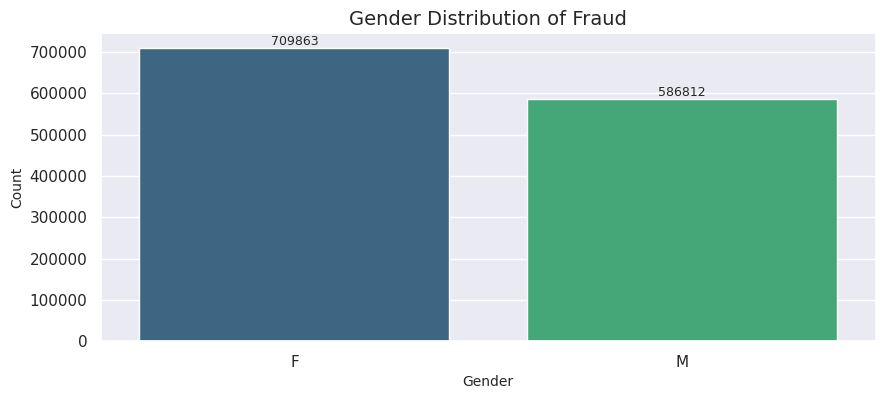

In [39]:
## **Plot 4: Gender Distribution of Fraud**
plt.figure(figsize=(10, 4))
sns.countplot(x='gender', data=df, palette='viridis')
plt.title('Gender Distribution of Fraud', fontsize=14)
plt.ylabel('Count', fontsize=10)
plt.xlabel('Gender', fontsize=10)

# Annotate bars with counts
for p in plt.gca().patches:
    plt.annotate(f'{int(p.get_height())}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=9)
plt.show()

## **Job Category Distribution Plot**

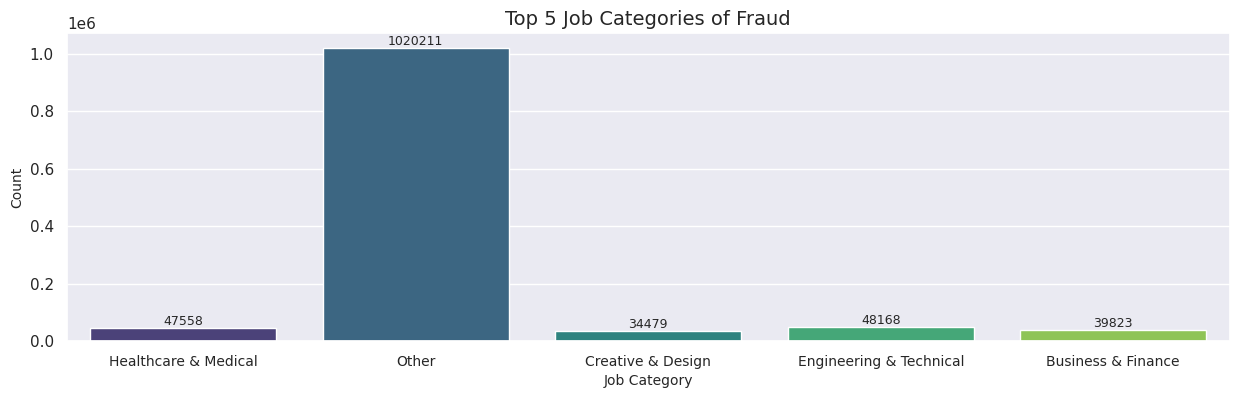

In [40]:
## **Plot 5: Job Category Distribution of Fraud**
plt.figure(figsize=(15, 4))
sns.countplot(x='job_category', data=df[df['job_category'].isin(top_job_categories)], palette='viridis')
plt.title('Top 5 Job Categories of Fraud', fontsize=14)
plt.ylabel('Count', fontsize=10)
plt.xlabel('Job Category', fontsize=10)
plt.xticks(rotation=0, fontsize=10)

# Annotate bars with counts
for p in plt.gca().patches:
    plt.annotate(f'{int(p.get_height())}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=9)
plt.show()

## **USA Region Distribution Plot**

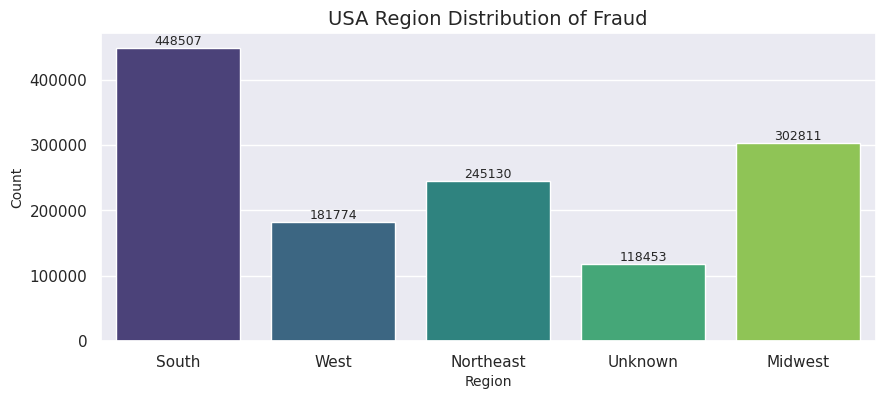

In [41]:
## **Plot 6: USA Region Distribution of Fraud**
plt.figure(figsize=(10, 4))
sns.countplot(x='usa_region', data=df[df['usa_region'].isin(top_regions)], palette='viridis')
plt.title('USA Region Distribution of Fraud', fontsize=14)
plt.ylabel('Count', fontsize=10)
plt.xlabel('Region', fontsize=10)

# Annotate bars with counts
for p in plt.gca().patches:
    plt.annotate(f'{int(p.get_height())}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=9)
plt.show()

## **State Distribution Plot**

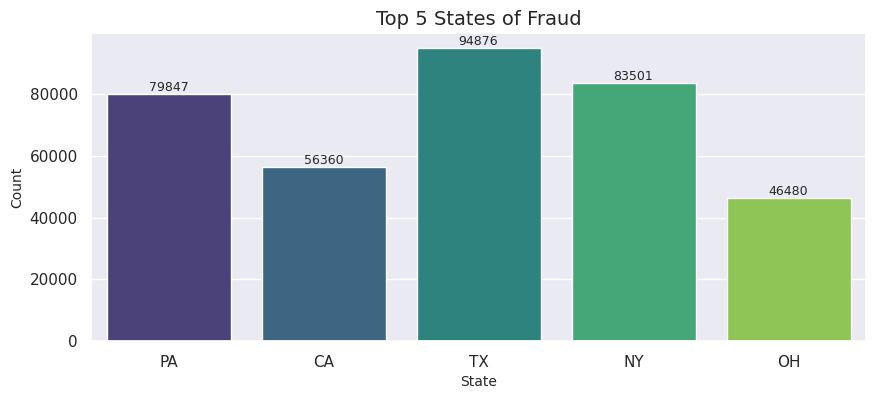

In [42]:
## **Plot 7: State Distribution of Fraud**
plt.figure(figsize=(10, 4))
sns.countplot(x='state', data=df[df['state'].isin(top_states)], palette='viridis')
plt.title('Top 5 States of Fraud', fontsize=14)
plt.ylabel('Count', fontsize=10)
plt.xlabel('State', fontsize=10)
plt.xticks(rotation=0)

# Annotate bars with counts
for p in plt.gca().patches:
    plt.annotate(f'{int(p.get_height())}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=9)
plt.show()

## **Merchant Distribution Plot**

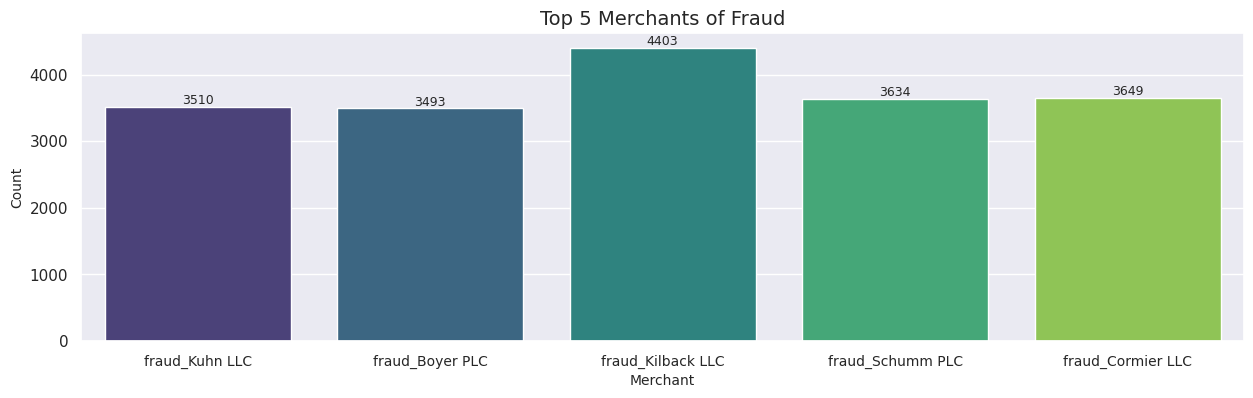

In [43]:
## **Plot 8: Merchant Distribution of Fraud**
plt.figure(figsize=(15, 4))
sns.countplot(x='merchant', data=df[df['merchant'].isin(top_merchants)], palette='viridis')
plt.title('Top 5 Merchants of Fraud', fontsize=14)
plt.ylabel('Count', fontsize=10)
plt.xlabel('Merchant', fontsize=10)
plt.xticks(rotation=0, fontsize=10)

# Annotate bars with counts
for p in plt.gca().patches:
    plt.annotate(f'{int(p.get_height())}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=9)
plt.show()

## **Transaction Time Category Distribution for Fraud**

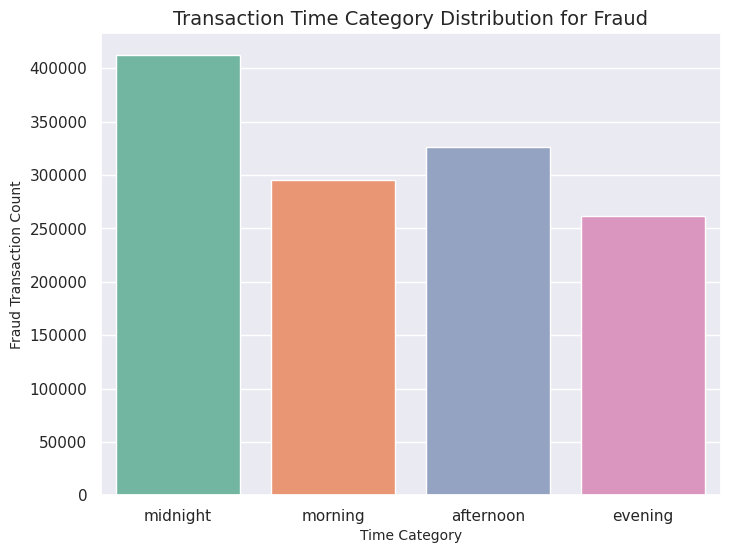

In [44]:
## **Plot 9: Transaction Time Category Distribution for Fraud**
plt.figure(figsize=(8, 6))
sns.countplot(x='time_category', data=df, palette='Set2')
plt.title('Transaction Time Category Distribution for Fraud', fontsize=14)
plt.xlabel('Time Category', fontsize=10)
plt.ylabel('Fraud Transaction Count', fontsize=10)
plt.show()

## **Number of Fraudulent Transactions by Hour of Day**

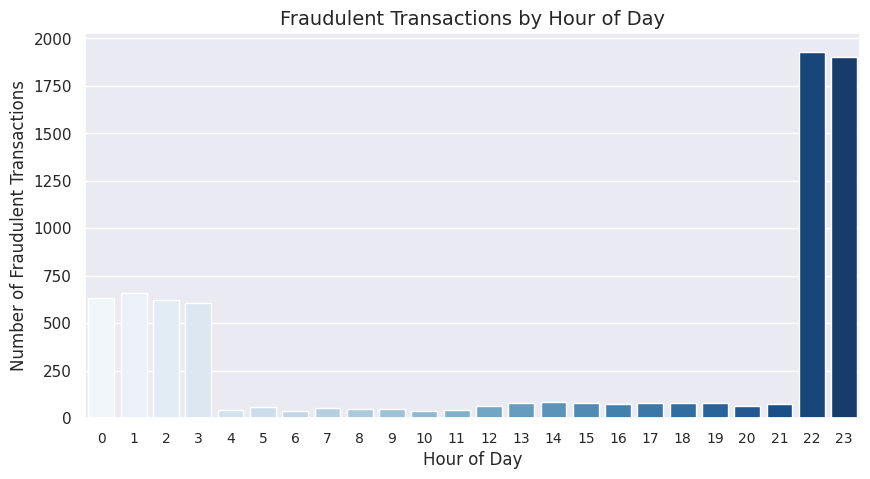

In [49]:
## **Plot 10: Number of Fraudulent Transactions by Hour of Day**
# Extract hour from the datetime column
df['hour_of_day'] = df['trans_date_trans_time'].dt.hour

# Grouping data by hour of the day for fraudulent transactions
hourly_fraud_data = df[df['is_fraud'] == 1].groupby(by='hour_of_day').agg({'trans_num': 'count'}).reset_index()

# Create the bar plot for fraudulent transactions by hour
plt.figure(figsize=(10, 5))
sns.barplot(data=hourly_fraud_data, x='hour_of_day', y='trans_num', palette='Blues')
plt.title('Fraudulent Transactions by Hour of Day', fontsize=14)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Number of Fraudulent Transactions', fontsize=12)
plt.xticks(fontsize=10)
plt.show()

## **Weekly Distribution for Fraudulent vs Genuine Transactions**

In [50]:
## **Plot 11: Weekly Distribution of Fraudulent vs Non-Fraudulent Transactions**
# Create a new column for the week number
df['week'] = df['trans_date_trans_time'].dt.isocalendar().week

# Plotting the weekly counts
fig_weekly = make_subplots(rows=2, cols=1, subplot_titles=("Weekly Distribution of Non-Fraudulent Transactions", "Weekly Distribution of Fraudulent Transactions"))

# Non-fraudulent transactions
non_fraud_counts = df[df['is_fraud'] == 0].groupby('week').size().reset_index(name='counts')
fig_weekly.add_trace(go.Bar(x=non_fraud_counts['week'], y=non_fraud_counts['counts'], name='Non-Fraud', marker_color='#61E50F'), row=1, col=1)

# Fraudulent transactions
fraud_counts = df[df['is_fraud'] == 1].groupby('week').size().reset_index(name='counts')
fig_weekly.add_trace(go.Bar(x=fraud_counts['week'], y=fraud_counts['counts'], name='Fraud', marker_color='#D93C1D'), row=2, col=1)

# Update layout
fig_weekly.update_layout(title_text="Weekly Distribution of Transactions", height=600)
fig_weekly.show()

## **Percentage Difference of Fraudulent vs Genuine Transactions by Category**

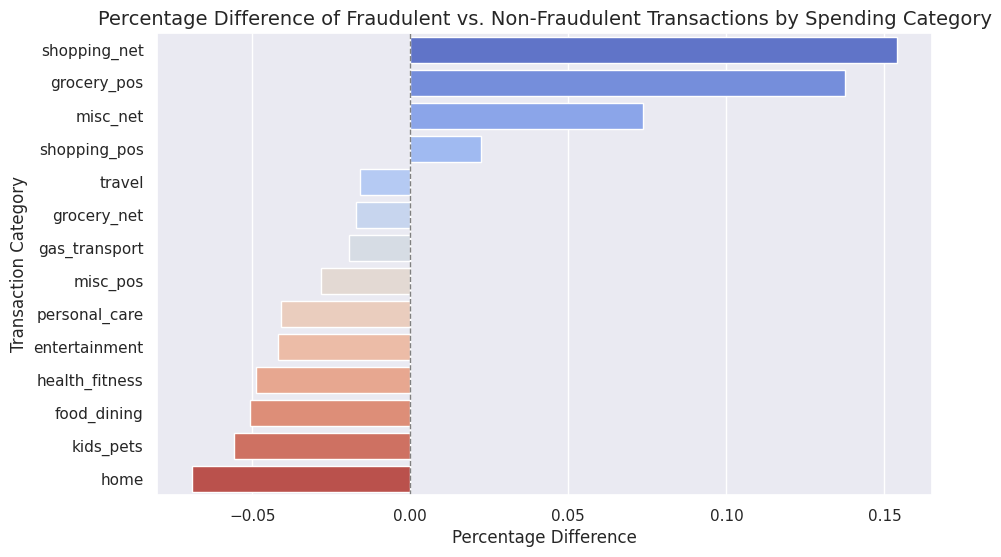

In [51]:
## **Plot 12: Percentage Difference of Fraudulent vs. Non-Fraudulent Transactions by Category**
# Calculate percentages for categories
not_fraud_stats = df[df['is_fraud'] == 0]['category'].value_counts(normalize=True).to_frame().reset_index()
not_fraud_stats.columns = ['category', 'Not Fraud Percentage']

fraud_stats = df[df['is_fraud'] == 1]['category'].value_counts(normalize=True).to_frame().reset_index()
fraud_stats.columns = ['category', 'Fraud Percentage']

# Merge DataFrames and calculate difference
percentage_diff = not_fraud_stats.merge(fraud_stats, on='category')
percentage_diff['Difference'] = percentage_diff['Fraud Percentage'] - percentage_diff['Not Fraud Percentage']

# Create a bar plot for percentage differences
plt.figure(figsize=(10, 6))
ax = sns.barplot(y='category', x='Difference', data=percentage_diff.sort_values('Difference', ascending=False), palette='coolwarm')
ax.set_xlabel('Percentage Difference')
ax.set_ylabel('Transaction Category')
plt.title('Percentage Difference of Fraudulent vs. Non-Fraudulent Transactions by Spending Category', fontsize=14)
plt.axvline(0, color='grey', linestyle='--', linewidth=1)  # Reference line at x=0
plt.show()

## **Age Distribution of Fraudulent vs Genuine Transactions**

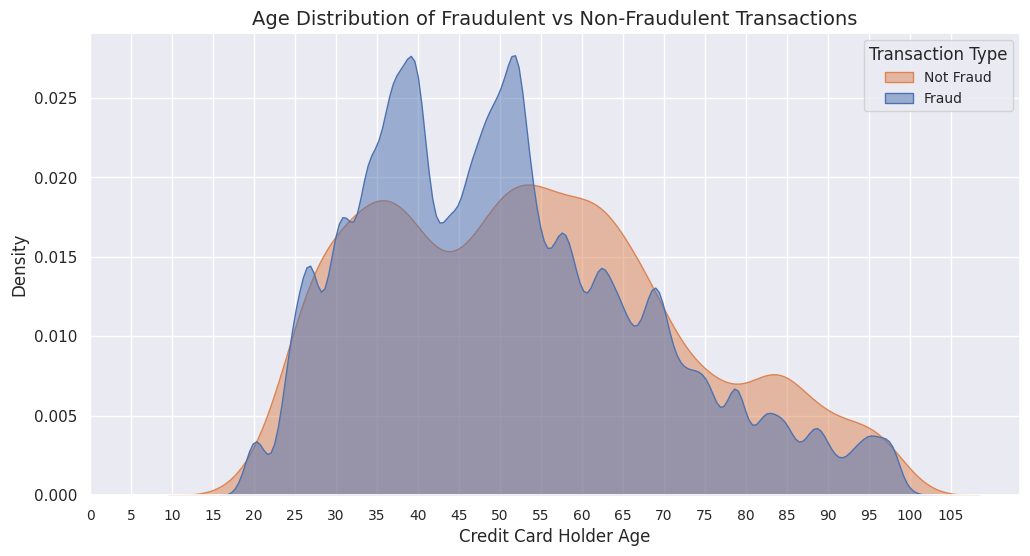

In [52]:
## **Plot 13: Age Distribution of Fraudulent vs Non-Fraudulent Transactions**
plt.figure(figsize=(12, 6))
ax = sns.kdeplot(x='age', data=df, hue='is_fraud', common_norm=False, fill=True, alpha=0.5)
ax.set_xlabel('Credit Card Holder Age', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
plt.xticks(np.arange(0, 110, 5), fontsize=10)
plt.title('Age Distribution of Fraudulent vs Non-Fraudulent Transactions', fontsize=14)
plt.legend(title='Transaction Type', labels=['Not Fraud', 'Fraud'], fontsize=10)
plt.grid(True)
plt.show()

## **Percentage Difference of Fraudulent vs Genuine Transactions by State**

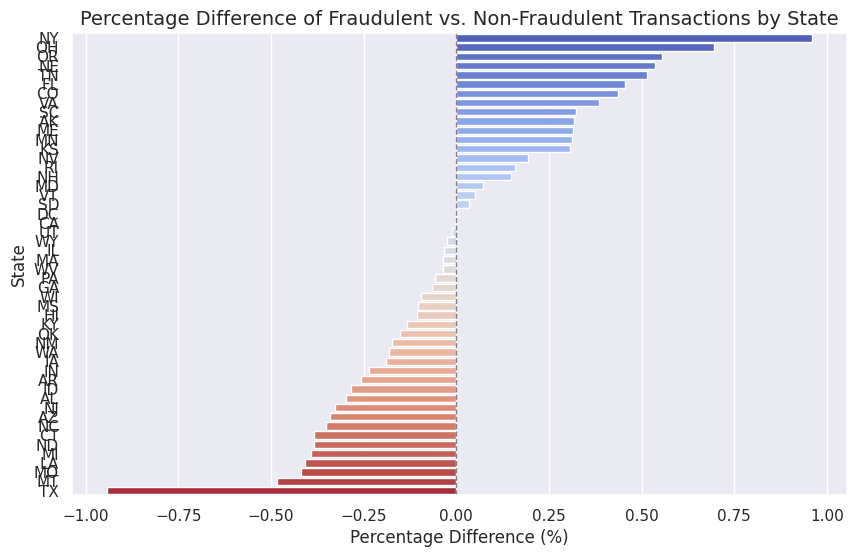

In [53]:
## **Plot 14: Percentage Difference of Fraudulent vs. Non-Fraudulent Transactions by State**
# Calculate percentages by state
fraudulent_percentage = df['state'][df.is_fraud == 1].value_counts(normalize=True).reset_index()
fraudulent_percentage.columns = ['State', 'Fraud Percentage']

non_fraudulent_percentage = df['state'][df.is_fraud == 0].value_counts(normalize=True).reset_index()
non_fraudulent_percentage.columns = ['State', 'Non-Fraud Percentage']

# Merge DataFrames and calculate difference
merged = non_fraudulent_percentage.merge(fraudulent_percentage, on='State')
merged['Difference'] = (merged['Fraud Percentage'] - merged['Non-Fraud Percentage']) * 100
merged = merged.sort_values('Difference', ascending=False)

# Create a bar plot for percentage differences
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(data=merged, x='Difference', y='State', palette='coolwarm')
ax1.set_xlabel('Percentage Difference (%)', fontsize=12)
ax1.set_ylabel('State', fontsize=12)
plt.title('Percentage Difference of Fraudulent vs. Non-Fraudulent Transactions by State', fontsize=14)
plt.axvline(0, color='grey', linestyle='--', linewidth=1)  # Reference line at x=0
plt.show()

# **Outlier Detection and Testing**

## **Outlier Visualization**

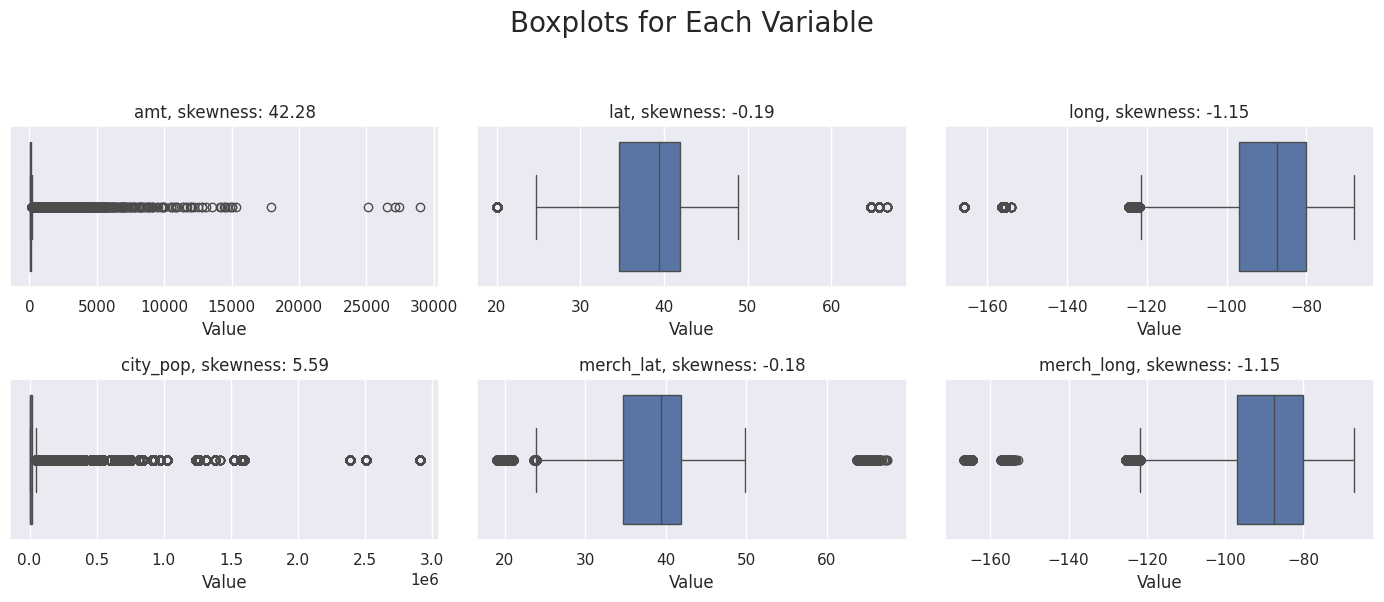

In [54]:
# Define numeric columns for analysis
numeric_columns = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']

# Function to create boxplots for specified numeric columns
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(14, 6))
    fig.suptitle(suptitle, y=1, size=20)
    axs = axs.flatten()

    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(f"{data}, skewness: {round(dataset[data].skew(axis=0, skipna=True), 2)}")
        axs[i].set_xlabel('Value')

    for j in range(i + 1, rows * cols):
        fig.delaxes(axs[j])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Create boxplots for the numeric columns
boxplots_custom(dataset=df, columns_list=numeric_columns, rows=2, cols=3, suptitle='Boxplots for Each Variable')

## **Outlier Definitive Detection using IQR Method**

In [55]:
# Function to detect outliers using the IQR method
def IQR_method(df, n, features):
    outlier_list = []
    for column in features:
        Q1 = np.percentile(df[column], 25)
        Q3 = np.percentile(df[column], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step)].index
        outlier_list.extend(outlier_list_column)
    outlier_list = Counter(outlier_list)
    multiple_outliers = [k for k, v in outlier_list.items() if v > n]
    return multiple_outliers

# Detect outliers in the dataset
Outliers_IQR = IQR_method(df, 1, numeric_columns)

# Clean the dataset by dropping outliers
df_outliers = df.drop(Outliers_IQR, axis=0).reset_index(drop=True)
df_outliers = df.loc[Outliers_IQR].reset_index(drop=True)

## **Class Distribution in Outlier Free Dataset**

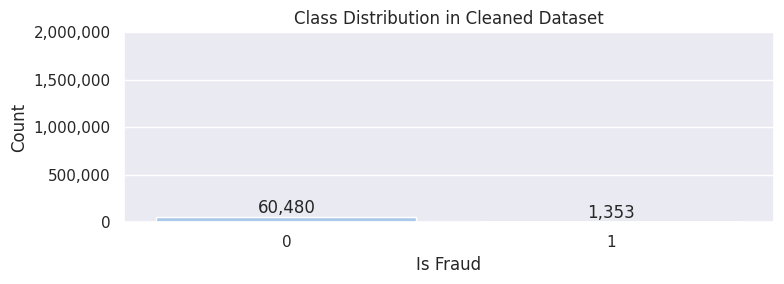

In [57]:
# Check the class distribution in the cleaned dataset
plt.figure(figsize=(8, 3))
ax = sns.countplot(x='is_fraud', data=df_outliers, palette="pastel")

for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

ax.set_ylim(0, 2.0e6)

# Function to format y-axis tick labels
def comma_format(x, pos):
    return '{:,.0f}'.format(x)

ax.yaxis.set_major_formatter(FuncFormatter(comma_format))

plt.title("Class Distribution in Cleaned Dataset")
plt.xlabel("Is Fraud")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# **Normality Check**

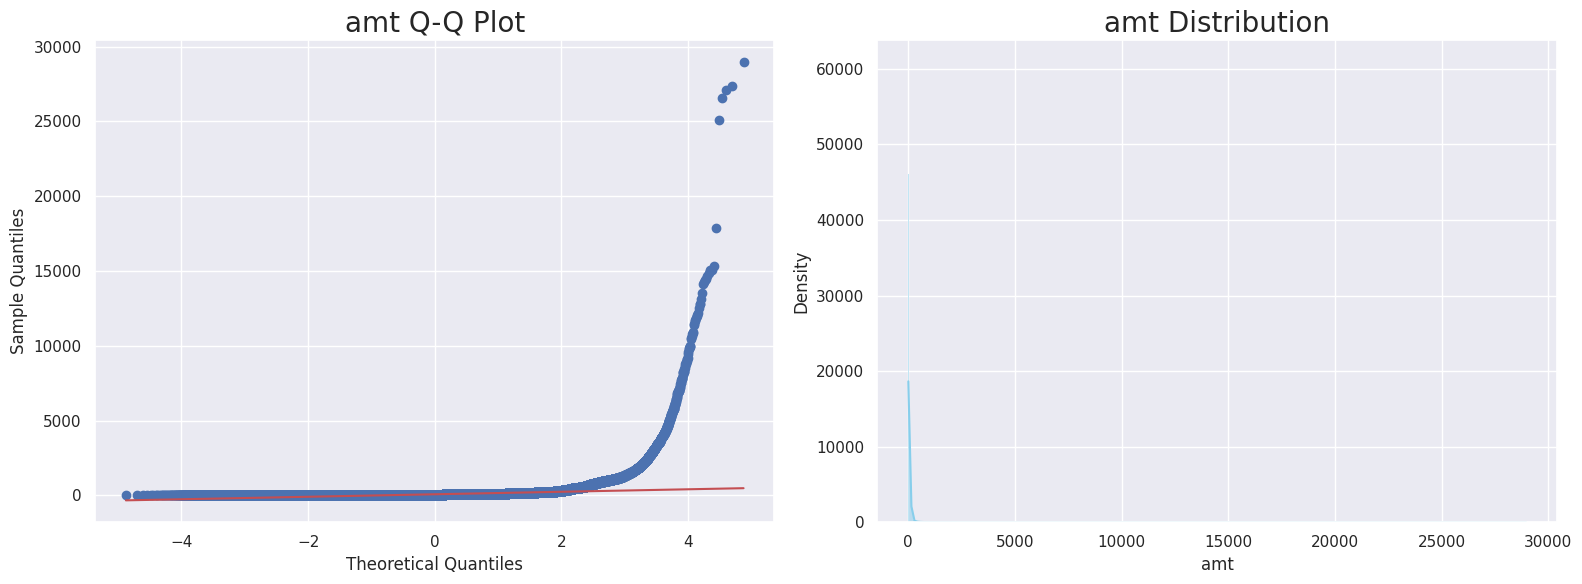

amt: mean=70.3510, std=160.3160, skew=42.2779


In [58]:
# Function to check normality using Q-Q plot and plot histogram side by side
def check_normality_and_plot(feature):
    # Create subplots: 1 row, 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Q-Q Plot
    stats.probplot(df[feature], dist=stats.norm, plot=axs[0])
    axs[0].set_title(f'{feature} Q-Q Plot', fontsize=20)
    axs[0].set_xlabel('Theoretical Quantiles')
    axs[0].set_ylabel('Sample Quantiles')

    # Histogram with density
    sns.histplot(df[feature], kde=True, ax=axs[1], color='skyblue')
    axs[1].set_title(f'{feature} Distribution', fontsize=20)
    axs[1].set_xlabel(feature)
    axs[1].set_ylabel('Density')

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Print statistics for the feature
    mean = df[feature].mean()
    std = df[feature].std()
    skew_val = df[feature].skew()
    print(f'{feature}: mean={mean:.4f}, std={std:.4f}, skew={skew_val:.4f}')

# Usage
check_normality_and_plot("amt")


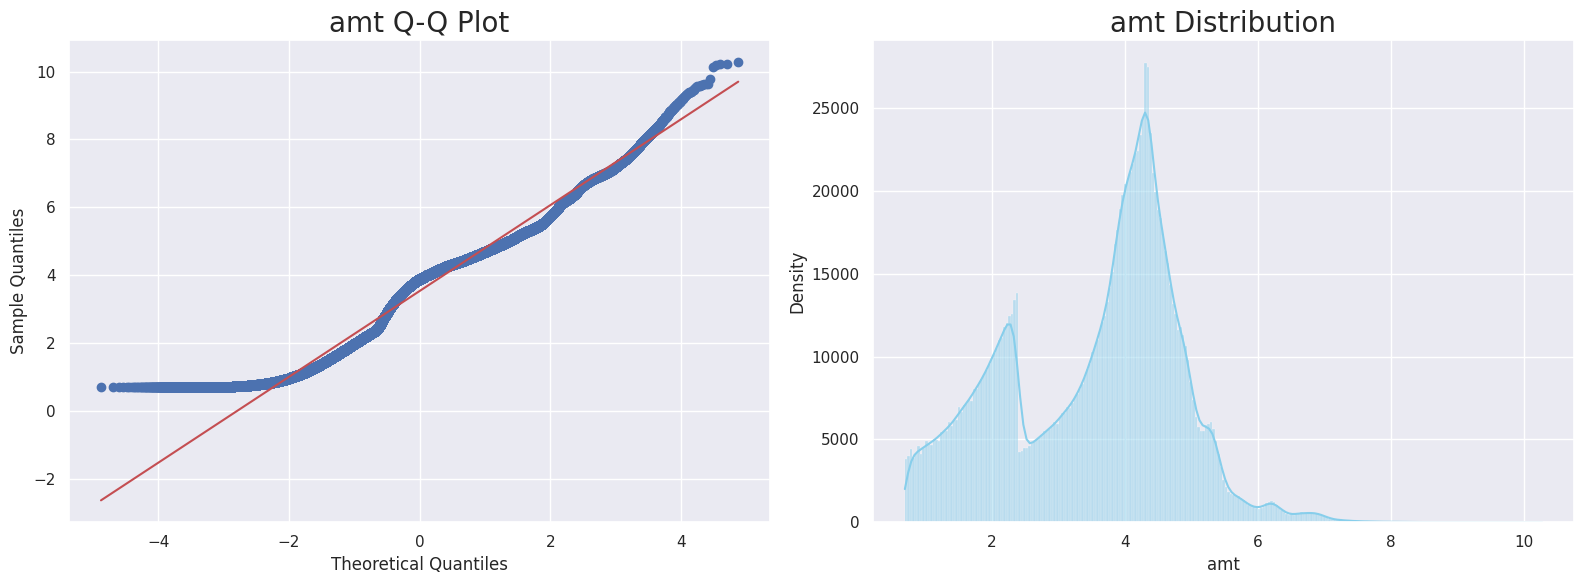

amt: mean=3.5335, std=1.2894, skew=-0.2989


In [59]:
# Apply logarithmic scaling to the 'amt' feature
df['amt'] = np.log1p(df['amt'])

# Plot histogram after log scaling for 'amt'
check_normality_and_plot("amt")

# **Final Dataframe**

## **Correlation Heatmap Check**

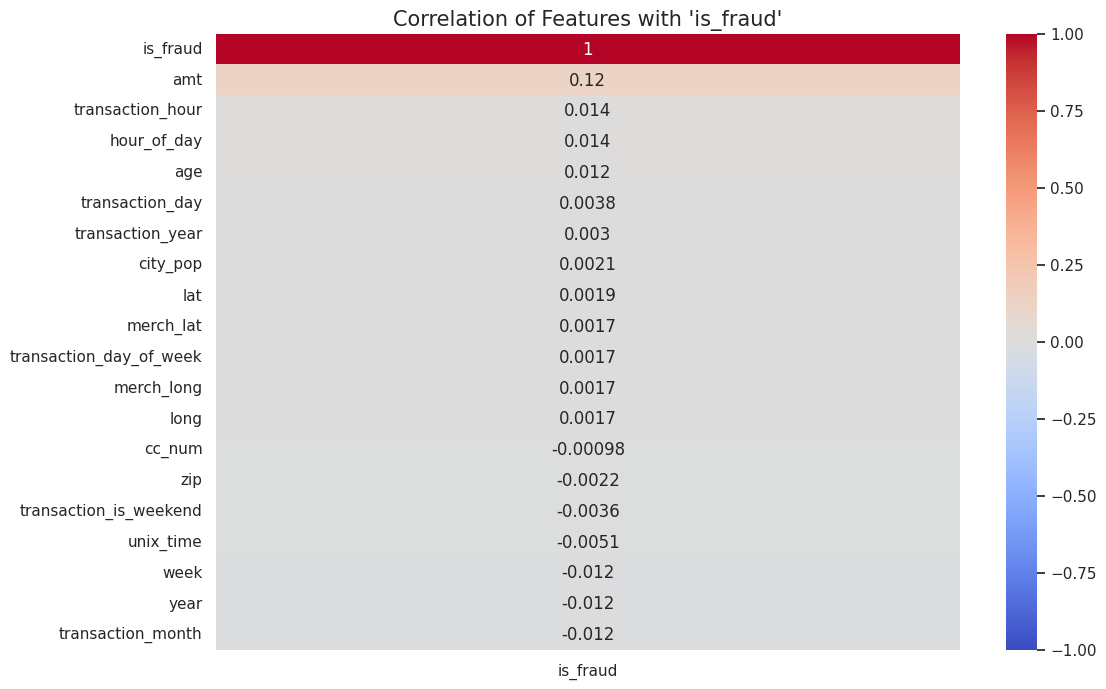

In [60]:
# Create a correlation heatmap for numeric features
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[['is_fraud']].sort_values(by='is_fraud', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation of Features with 'is_fraud'", size=15)
plt.show()

## **Final Column Drop**

In [65]:
# Dropping unnecessary columns from the dataset
df_final = df.drop(columns=[
    'cc_num',
    'merchant',
    'first',
    'last',
    'street',
    'city',
    'state',
    'zip',
    'dob',
    'trans_num',
    'unix_time',
    'lat',
    'long',
    'merch_lat',
    'merch_long',
    'trans_date_trans_time',
    'transaction_year',
    'transaction_time',
    'job',
    'job_category',
    'usa_region',
    'hour_of_day',
    'week',
    'city_pop',
    'gender',
    'age',
    'year',
])

df_final

,category,amt,is_fraud,transaction_month,transaction_day,transaction_hour,transaction_day_of_week,transaction_is_weekend,time_category
0,misc_net,1.786747,0,1,1,0,1,0,midnight
1,grocery_pos,4.684259,0,1,1,0,1,0,midnight
2,entertainment,5.398660,0,1,1,0,1,0,midnight
3,gas_transport,3.828641,0,1,1,0,1,0,midnight
4,misc_pos,3.760269,0,1,1,0,1,0,midnight
...,...,...,...,...,...,...,...,...,...
1296670,entertainment,2.806990,0,6,21,12,6,1,afternoon
1296671,food_dining,3.964615,0,6,21,12,6,1,afternoon
1296672,food_dining,4.672174,0,6,21,12,6,1,afternoon
1296673,food_dining,4.329417,0,6,21,12,6,1,afternoon


In [66]:
# Label encoding for categorical features
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df_final['category'] = le.fit_transform(df_final['category'])
df_final['time_category'] = le.fit_transform(df_final['time_category'])

# Display the final processed DataFrame
df_final.head()

,category,amt,is_fraud,transaction_month,transaction_day,transaction_hour,transaction_day_of_week,transaction_is_weekend,time_category
0,8,1.786747,0,1,1,0,1,0,2
1,4,4.684259,0,1,1,0,1,0,2
2,0,5.398660,0,1,1,0,1,0,2
3,2,3.828641,0,1,1,0,1,0,2
4,9,3.760269,0,1,1,0,1,0,2


## **Save to CSV**

In [67]:
df_final.to_csv('df_final.csv', index=False)